In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle as pkl

import seaborn as sb
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [5]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_res_panc=path_data+'pancreas_conditions_MIA_HPAP2/'

In [6]:
path_fig=path_data+'figures/'

In [7]:
# Load distances from mouse-human dataset
distances=pkl.load(open(path_res_panc+'combined_orthologuesHVG_PcaSysBatchDist.pkl','rb'))

In [8]:
# Prepare df for plotting (focus on delta cells)
plot=[]
ct='delta'
dat=distances[ct]
y_col='Compared samples'
for comparison,dist in dat.items():
    dist=pd.DataFrame(dist,columns=['dist'])
    dist['group']=ct
    dist[y_col]=comparison
    plot.append(dist)
plot=pd.concat(plot)

In [9]:
# Make data names prettier
plot.rename({'dist':'Distance'},axis=1,inplace=True)
plot.replace({'s0_within':'Mouse\n(within datasets)',
              's0_between':'Mouse\n(between datasets)',
              's1':'Human',
              's0s1':'Mouse vs human'},inplace=True)

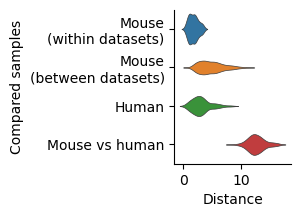

In [10]:
# Plot
fig,ax=plt.subplots(figsize=(1.5,2))
sb.violinplot(y=y_col,x='Distance',data=plot,inner=None,linewidth=0.5,ax=ax)
fig.set(facecolor = (0,0,0,0))
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(path_fig+f'batch_strength-pancreas_{ct}-violin.pdf',dpi=300,bbox_inches='tight')
plt.savefig(path_fig+f'batch_strength-pancreas_{ct}-violin.png',dpi=300,bbox_inches='tight')

In [11]:
# N comparisons (samples) per group
plot.groupby(y_col).size()

Compared samples
Human                         136
Mouse\n(between datasets)    1010
Mouse\n(within datasets)      166
Mouse vs human                833
dtype: int64